### Table of Contents

- [1. Import Packages](#import)
- [2. Load Data](#load)
- [3. Num of Ships per Type](#num)
- [4. Dist Travelled](#dist)
- [5. Collect DWT Data](#dwt_collect)
- [6. Emmission Profiles](#emis)
- [7. Emmission Intensity vs DWT](#dwt)

<a id='import'></a>
### Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup as bs
import json

<a id='load'></a>
### Load in the data

This assumes that data has been downloaded manually from https://mrv.emsa.europa.eu/#public/emission-report

for 2018, 19, 20, 21

In [2]:
os.getcwd()

'/Users/u1079317/Desktop/analysis'

In [3]:
#Replace space in file names with _
os.chdir('/Users/u1079317/Desktop/analysis/data')
for f in os.listdir(os.getcwd()):
    if '.xlsx' in f:
        os.rename(f, f.replace(' ','_'))

In [8]:
for f in os.listdir(os.getcwd()):
    if 'xlsx' in f:
        print(f)

2018-v267-24062022-EU_MRV_Publication_of_information.xlsx
2019-v208-29062022-EU_MRV_Publication_of_information.xlsx
2020-v166-26072022-EU_MRV_Publication_of_information.xlsx
2021-v28-09082022-EU_MRV_Publication_of_information.xlsx


In [10]:
dfs = [pd.read_excel(f, skiprows=2, engine='openpyxl') for f in os.listdir(os.getcwd()) if 'xlsx' in f]

/Users/u1079317/Desktop/analysis/venv/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/u1079317/Desktop/analysis/venv/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/u1079317/Desktop/analysis/venv/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/u1079317/Desktop/analysis/venv/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [11]:
#Rename columns to prevent spaces in words. Replace with "_"
for d in dfs:
    d.columns = [c.replace(' ','_') for c in d.columns]

In [12]:
#Check whether columns match 
res = {}
for i, d in enumerate(dfs):
    for j, d2 in enumerate(dfs):
        if i != j and not res.get(f'comparing_{"_".join(map(str,sorted([i,j])))}'):
            res[f'comparing_{"_".join(map(str,sorted([i,j])))}'] = f'columns match: {sum(d.columns == d2.columns)}'
            print(f'comparing_{"_".join(map(str,sorted([i,j])))}: columns match: {sum(d.columns == d2.columns)}')

comparing_0_1: columns match: 61
comparing_0_2: columns match: 59
comparing_0_3: columns match: 59
comparing_1_2: columns match: 59
comparing_1_3: columns match: 59
comparing_2_3: columns match: 61


In [13]:
#Some columns for 2018-19 don't match with 2020-21. Manually Correct
dfs[0].columns[list(np.where(np.array(dfs[0].columns == dfs[3].columns) == False)[0])]
dfs[3].columns[list(np.where(np.array(dfs[3].columns == dfs[0].columns) == False)[0])]

Index(['Annual_Time_spent_at_sea_[hours]', 'Time_spent_at_sea_[hours]'], dtype='object')

In [14]:
dfs[3].rename(columns={'Annual_Time_spent_at_sea_[hours]':'Annual_Total_time_spent_at_sea_[hours]',
                       'Time_spent_at_sea_[hours]':'Total_time_spent_at_sea_[hours]'}, 
              inplace=True)

In [15]:
dfs[2].rename(columns={'Annual_Time_spent_at_sea_[hours]':'Annual_Total_time_spent_at_sea_[hours]',
                       'Time_spent_at_sea_[hours]':'Total_time_spent_at_sea_[hours]'}, 
              inplace=True)

In [16]:
df_c = pd.concat(dfs)

In [17]:
df_c.shape

(48559, 61)

<a id='num'></a>
### Calculate the number of ships in each type:

IMO_Number for a vessel remains constant, but the ownership can change along with the name. There is evidence of this for [SONGA PUMAContainer Ship, IMO 9399789](https://www.vesselfinder.com/vessels/SONGA-PUMA-IMO-9399789-MMSI-636020352)

This shows that the vessel name has changed several times since 2009. Due to name changes, it will be most appropriate to perform any aggregations on the IMO as the unique identifier.

There are some ships which have multiple ship types associated to a single IMO_Number.

e.g

[SONATA](https://www.vesselfinder.com/vessels/SONATA-IMO-9316103-MMSI-277562000) which is listed as Other, Cargo and Container ship.

In [18]:
df_c.groupby('Ship_type').IMO_Number.nunique().sort_values(ascending=False)

Ship_type
Bulk carrier                  6411
Oil tanker                    2940
Container ship                2565
Chemical tanker               1963
General cargo ship            1618
Vehicle carrier                588
Gas carrier                    539
Ro-pax ship                    434
LNG carrier                    381
Ro-ro ship                     325
Other ship types               276
Passenger ship                 238
Refrigerated cargo carrier     202
Container/ro-ro cargo ship      89
Combination carrier             18
Name: IMO_Number, dtype: int64

In [19]:
df_c.groupby('Ship_type').Name.nunique().sort_values(ascending=False)

Ship_type
Bulk carrier                  6806
Oil tanker                    3094
Container ship                2895
Chemical tanker               2152
General cargo ship            1834
Vehicle carrier                606
Gas carrier                    563
Ro-pax ship                    467
LNG carrier                    388
Ro-ro ship                     354
Other ship types               288
Passenger ship                 240
Refrigerated cargo carrier     220
Container/ro-ro cargo ship      90
Combination carrier             18
Name: Name, dtype: int64

In [20]:
df_c.groupby('IMO_Number').Name.nunique().sort_values(ascending=False)

IMO_Number
9399789    4
9438444    3
9353084    3
9458975    3
9246346    3
          ..
9377652    1
9377664    1
9377688    1
9377690    1
9924912    1
Name: Name, Length: 18191, dtype: int64

In [21]:
#Investigation of ships history shows that the name has changed multiple times:
#Therefore more appropritate to sort by IMO_Number which remains constant
df_c[df_c['IMO_Number'] == 9399789]

,IMO_Number,Name,Ship_type,Reporting_Period,Technical_efficiency,Port_of_Registry,Home_Port,Ice_Class,DoC_issue_date,DoC_expiry_date,...,Fuel_consumption_per_transport_work_(pax)_on_laden_voyages_[g_/_pax_·_n_miles],Fuel_consumption_per_transport_work_(freight)_on_laden_voyages_[g_/_m_tonnes_·_n_miles],CO₂_emissions_per_distance_on_laden_voyages_[kg_CO₂_/_n_mile],CO₂_emissions_per_transport_work_(mass)_on_laden_voyages_[g_CO₂_/_m_tonnes_·_n_miles],CO₂_emissions_per_transport_work_(volume)_on_laden_voyages_[g_CO₂_/_m³_·_n_miles],CO₂_emissions_per_transport_work_(dwt)_on_laden_voyages_[g_CO₂_/_dwt_carried_·_n_miles],CO₂_emissions_per_transport_work_(pax)_on_laden_voyages_[g_CO₂_/_pax_·_n_miles],CO₂_emissions_per_transport_work_(freight)_on_laden_voyages_[g_CO₂_/_m_tonnes_·_n_miles],Additional_information_to_facilitate_the_understanding_of_the_reported_average_operational_energy_efficiency_indicators,Average_density_of_the_cargo_transported_[m_tonnes_/_m³]
5429,9399789,CAP ROCA,Container ship,2018,NaN,NaN,NaN,NaN,02/04/2019,30/06/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5254,9399789,ALGARROBO,Container ship,2019,EEDI (17.87 gCO₂/t·nm),Monrovia,NaN,NaN,29/07/2020,30/06/2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4829,9399789,ROBIN 1,Container ship,2020,EIV (11.87 gCO₂/t·nm),Monrovia,NaN,NaN,17/04/2021,30/06/2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4380,9399789,SONGA PUMA,Container ship,2021,EEDI (17.87 gCO₂/t·nm),Monrovia,NaN,NaN,27/06/2022,30/06/2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
#Some ships appear to have multiple Ship Types associated with them

df_c[['IMO_Number','Ship_type']]\
.drop_duplicates()\
.groupby('IMO_Number')\
.count()\
.sort_values(by='Ship_type', ascending=False)

,Ship_type
IMO_Number,
9316103,3
9180968,3
9306835,3
9186687,3
9771913,3
...,...
9365623,1
9365635,1
9365659,1


In [23]:
#Ship Type Does NOT remain const for a ship. Cargo and 
df_c[df_c['IMO_Number'] == 9316103]

,IMO_Number,Name,Ship_type,Reporting_Period,Technical_efficiency,Port_of_Registry,Home_Port,Ice_Class,DoC_issue_date,DoC_expiry_date,...,Fuel_consumption_per_transport_work_(pax)_on_laden_voyages_[g_/_pax_·_n_miles],Fuel_consumption_per_transport_work_(freight)_on_laden_voyages_[g_/_m_tonnes_·_n_miles],CO₂_emissions_per_distance_on_laden_voyages_[kg_CO₂_/_n_mile],CO₂_emissions_per_transport_work_(mass)_on_laden_voyages_[g_CO₂_/_m_tonnes_·_n_miles],CO₂_emissions_per_transport_work_(volume)_on_laden_voyages_[g_CO₂_/_m³_·_n_miles],CO₂_emissions_per_transport_work_(dwt)_on_laden_voyages_[g_CO₂_/_dwt_carried_·_n_miles],CO₂_emissions_per_transport_work_(pax)_on_laden_voyages_[g_CO₂_/_pax_·_n_miles],CO₂_emissions_per_transport_work_(freight)_on_laden_voyages_[g_CO₂_/_m_tonnes_·_n_miles],Additional_information_to_facilitate_the_understanding_of_the_reported_average_operational_energy_efficiency_indicators,Average_density_of_the_cargo_transported_[m_tonnes_/_m³]
3473,9316103,HANSE FORTUNE,Other ship types,2019,EIV (22.9 gCO₂/t·nm),Klaipeda,Klaipeda,NaN,06/04/2020,30/06/2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3109,9316103,SONATA,Container ship,2020,EIV (22.9 gCO₂/t·nm),Klaipeda,NaN,NaN,18/02/2021,30/06/2022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2742,9316103,SONATA,General cargo ship,2021,EIV (22.9 gCO₂/t·nm),Klaipeda,NaN,NaN,13/04/2022,30/06/2023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id='dist'></a>
### Total Distance Travelled By Each Ship

In [24]:
cols_of_interest = ['IMO_Number',
                    'Reporting_Period',
                    'Total_fuel_consumption_[m_tonnes]',
                    'Total_CO₂_emissions_[m_tonnes]',
                    'Total_time_spent_at_sea_[hours]',
                    'Annual_average_Fuel_consumption_per_distance_[kg_/_n_mile]',
                    'Annual_average_Fuel_consumption_per_transport_work_(dwt)_[g_/_dwt_carried_·_n_miles]',
                    'Annual_average_Fuel_consumption_per_transport_work_(mass)_[g_/_m_tonnes_·_n_miles]'
                  ]

for c in cols_of_interest:
    df_c[c] = pd.to_numeric(df_c[c], errors='coerce')

df_dist = df_c[cols_of_interest].copy()

In [25]:
df_dist.head(2)

,IMO_Number,Reporting_Period,Total_fuel_consumption_[m_tonnes],Total_CO₂_emissions_[m_tonnes],Total_time_spent_at_sea_[hours],Annual_average_Fuel_consumption_per_distance_[kg_/_n_mile],Annual_average_Fuel_consumption_per_transport_work_(dwt)_[g_/_dwt_carried_·_n_miles],Annual_average_Fuel_consumption_per_transport_work_(mass)_[g_/_m_tonnes_·_n_miles]
0,5383304,2018,6307.75,20080.25,4170.20,139.07,NaN,NaN
1,6417097,2018,8125.56,25689.03,4360.57,143.81,NaN,NaN


In [26]:
#Missing approx 3.5% of data required for calc
missing_fuel_data = 100 * df_dist['Annual_average_Fuel_consumption_per_distance_[kg_/_n_mile]'].isna().sum() / df_dist.shape[0]
print(f"Missing {missing_fuel_data :.2f}% of data required for calc")

Missing 3.43% of data required for calc


In [27]:
df_dist['est_dist_annual[n_miles]'] = 1e3 * df_dist['Total_fuel_consumption_[m_tonnes]'] / df_dist['Annual_average_Fuel_consumption_per_distance_[kg_/_n_mile]']

In [28]:
df_dist.shape

(48559, 9)

In [29]:
df_c.shape

(48559, 61)

In [30]:
#Total Dist Travelled By Each Ship
df_dist.groupby('IMO_Number').sum()[['est_dist_annual[n_miles]']]\
.sort_values(by=['est_dist_annual[n_miles]'], ascending=False)\
.rename(columns={'est_dist_annual[n_miles]':'total_est_milage'}).head()

,total_est_milage
IMO_Number,
9336268,584726.550356
9319466,576432.323717
9319442,569940.140825
9351490,537273.921686
9351505,530678.331600


In [31]:
#Total Dist Travelled By Each Ship
df_dist.groupby('IMO_Number').sum()[['est_dist_annual[n_miles]']]\
.sort_values(by=['est_dist_annual[n_miles]'], ascending=False)\
.rename(columns={'est_dist_annual[n_miles]':'total_est_milage'}).tail()

,total_est_milage
IMO_Number,
9595175,0.0
9597020,0.0
9597032,0.0
9598153,0.0
9924912,0.0


#### Highest Milage
The ship with the highest total milage is [FINNLADY](https://www.vesselfinder.com/vessels/FINNLADY-IMO-9336268-MMSI-230987000) This is a Passenger / Ro-Ro Cargo Ship. This appears to a be significant underestimate after reviewing the data on vessel finder.

**This ship travelled ~270k nmiles in 2020 and 21. I've predicted at ~150K nmiles.**

This is likely due to the Average Fuel Consumption per Nautical Mile being lowered by idle time and when ships are anchored/docked but still consuming fuel.  

#### Lowest Milage

Some ships recorded zero fuel consumption e.g [BALI](https://www.vesselfinder.com/vessels/BALI-IMO-9597020-MMSI-229178000). This is clearly a data issue because a review of online data shows that this vessel has been covering approximately 130K nautical miles annualy.

#### Milage Per Ship Type
Heighest Aggregated Milage per Ship Type is for Ro-pax Ships (Roll-on/Roll-off passenger). 

Lowest Aggregated Milage per Ship Type is for Oil Tankers and Bulk Cargo. 


In [32]:
#Some ships appear to have multiple Ship Types associated with them

In [33]:
df_c[['IMO_Number','Ship_type']]\
.drop_duplicates()\
.groupby('IMO_Number')\
.count()\
.sort_values(by='Ship_type', ascending=False)

,Ship_type
IMO_Number,
9316103,3
9180968,3
9306835,3
9186687,3
9771913,3
...,...
9365623,1
9365635,1
9365659,1


In [34]:
#Just keep most recent ship type
df_dist.merge(df_c[['IMO_Number','Ship_type','Reporting_Period']]\
.sort_values(by='Reporting_Period', ascending=False)\
.drop_duplicates(subset=['IMO_Number','Ship_type'])[['IMO_Number','Ship_type']], 
              left_on='IMO_Number',
              right_on='IMO_Number',
              how='inner')\
.groupby('Ship_type')\
.mean()[['est_dist_annual[n_miles]']]\
.rename(columns={'est_dist_annual[n_miles]':'mean_dist_per_ship_type'})\
.sort_values(by='mean_dist_per_ship_type', ascending=False)

,mean_dist_per_ship_type
Ship_type,
Ro-pax ship,66525.757492
Ro-ro ship,62179.725994
Container/ro-ro cargo ship,52914.357275
Container ship,41294.075859
Refrigerated cargo carrier,36687.911262
Vehicle carrier,33096.620382
Passenger ship,33071.293765
LNG carrier,32306.870329
Combination carrier,29119.218329


In [35]:
#Take a look at the distribution of distance covered:
df_dist['est_dist_annual[n_miles]'].describe()

count     46892.000000
mean      28280.457632
std       21929.969471
min           1.000004
25%       11797.222880
50%       22208.783589
75%       38779.644003
max      313736.047275
Name: est_dist_annual[n_miles], dtype: float64

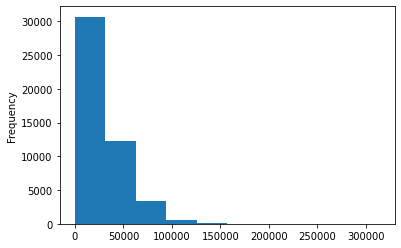

In [36]:
df_dist['est_dist_annual[n_miles]'].plot(kind='hist');

Majority of ships in this data set sailed less than 60,000 nautical miles. 

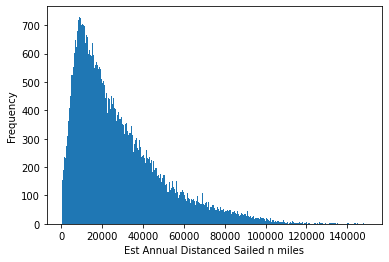

In [37]:
#Distribution of distance Sailed.
fig, ax = plt.subplots()
df_dist[(df_dist['est_dist_annual[n_miles]'] > 500) 
        & (df_dist['est_dist_annual[n_miles]'] <= 2e5)]['est_dist_annual[n_miles]']\
.plot(kind='hist', bins=np.arange(500,1.5e5, 500), ax=ax)
ax.set_xlabel('Est Annual Distanced Sailed n miles');

<a id='dwt_collect'></a>
### Collect DWT for Each Vessel

#Collect all ship summer DWT with webscraping

def find_dwt(imo: int, name: str,  headers: dict) -> str:
    """
    helper function to extract DWT from vessel finder.com
    
    args:
        imo: (int) - Unique identified of ship
        name: (str) - Name of ship
        headers: (dict) (str: str) - Headers to prevent 403 forbidden error - default to None
    
    returns:
        dwt (str): Summer Deadweight unit: t
    """
    
    resp = requests.get(f'https://www.vesselfinder.com/vessels/{name}-IMO-{imo}',
        headers=headers, timeout=5).text
    soup = bs(resp, 'html.parser')
    dwt_text = soup.find(lambda x: x.name == 'tr' and 'Deadweight' in x.text).text
    dwt = re.findall('\d{1,}', dwt_text)[0]
    return dwt

#Keep only most recent Name of ship
imo_name_dict = df_c[['IMO_Number','Name','Reporting_Period']]\
.sort_values(by=['Reporting_Period'], ascending=False)\
.drop_duplicates(subset=['IMO_Number'], keep='first')[['IMO_Number', 'Name']]\
.set_index('IMO_Number').to_dict()['Name']

tot_ships = len(list(imo_name_dict.keys()))

with open('config/variables.json','r') as f:
    headers = json.load(f)

for imo, name in imo_name_dict.items():
    if not imo_name_dwt.get(imo):
        try:
            if len(list(imo_name_dwt.keys())) % 250 == 0:
                print(f'Collecting DWT for [{len(list(imo_name_dwt.keys()))}/{tot_ships}]')
            imo_name_dwt[imo] = {'name':name, 'dwt':find_dwt(imo, name, headers)}
        except Exception as e:
            print(f"Failed on IMO:{imo}, Name:  {name}")
            print(f"Exception: {e}")

df_imo_dwt = {'imo':[], 'name':[], 'dwt':[]}

for k, v in imo_name_dwt.items():
    df_imo_dwt['imo'].append(k)
    df_imo_dwt['name'].append(v['name'])
    df_imo_dwt['dwt'].append(v['dwt'])

df_imo_dwt = pd.DataFrame(df_imo_dwt)

df_imo_dwt.to_csv('config/dwt_data.csv',index=False)

In [38]:
os.getcwd()

'/Users/u1079317/Desktop/analysis/data'

In [39]:
df_dwt = pd.read_csv('dwt_data.csv')

<a id='emiss'></a>
### Emission Profiles

How do the emissions profiles differ for the different ship types?


#### Defining a Metric for Emmissions
[Ref](https://www.dnv.com/maritime/insights/topics/CII-carbon-intensity-indicator/implementation.html)
CII = (Annual Fuel Consumption x CO2 Emmission Factor) / (Dist x DWT)

[Ref](https://www.verifavia-shipping.com/shipping-carbon-emissions-verification/faq-which-emission-factors-shall-be-used-110.php)
CO2 Emission Factor: Aware of range of factors: Heavy Fuel/Diesel 3.2 to Methanol 1.4

We can calculate our Emission factor for our Ships with:

Total CO2 Emissions / Total Fuel Consumption

In [40]:
df_dwt.rename(columns={'imo':'IMO_Number'}, inplace=True)

In [41]:
df_dist = df_dist.merge(df_dwt, on=['IMO_Number'], how='left')

In [42]:
df_dist = df_dist.merge(df_c[['IMO_Number','Reporting_Period','Ship_type']], 
              how='left', 
              left_on=['IMO_Number','Reporting_Period'],
              right_on=['IMO_Number','Reporting_Period'])

In [43]:
df_dist.head(2)

,IMO_Number,Reporting_Period,Total_fuel_consumption_[m_tonnes],Total_CO₂_emissions_[m_tonnes],Total_time_spent_at_sea_[hours],Annual_average_Fuel_consumption_per_distance_[kg_/_n_mile],Annual_average_Fuel_consumption_per_transport_work_(dwt)_[g_/_dwt_carried_·_n_miles],Annual_average_Fuel_consumption_per_transport_work_(mass)_[g_/_m_tonnes_·_n_miles],est_dist_annual[n_miles],name,dwt,Ship_type
0,5383304,2018,6307.75,20080.25,4170.20,139.07,NaN,NaN,45356.654922,ASTORIA,2153.0,Passenger ship
1,6417097,2018,8125.56,25689.03,4360.57,143.81,NaN,NaN,56502.051318,MARCO POLO,5180.0,Passenger ship


In [44]:
(df_dist['Total_CO₂_emissions_[m_tonnes]'] / df_dist['Total_fuel_consumption_[m_tonnes]']).describe()

count    46905.000000
mean         3.137369
std          0.172120
min          0.283173
25%          3.124532
50%          3.135251
75%          3.155029
max         30.092171
dtype: float64

<AxesSubplot:ylabel='Frequency'>

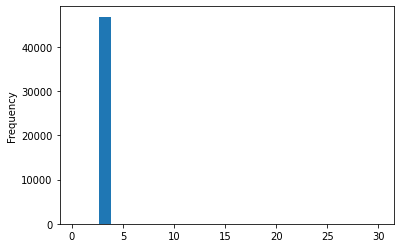

In [45]:
(df_dist['Total_CO₂_emissions_[m_tonnes]'] / df_dist['Total_fuel_consumption_[m_tonnes]']).plot(kind='hist', bins=25)

In [46]:
def CII(row):
    """
    
    Helper Function to Calculate CII for each row pandas df
    
    args:
        row: row of pandas df
        
    return:
        cii (float) - CII (g CO2 / (nm . tonne))
        
    """
    cii = (
    (1e6 * row['Total_CO₂_emissions_[m_tonnes]']) / 
    (row['est_dist_annual[n_miles]'] * row['dwt'])
    )
    
    return cii

In [47]:
df_dist['CII[gCO2/(nm . tonne)]'] = df_dist.apply(lambda x: CII(x), axis=1)

In [48]:
df_dist.head(2)

,IMO_Number,Reporting_Period,Total_fuel_consumption_[m_tonnes],Total_CO₂_emissions_[m_tonnes],Total_time_spent_at_sea_[hours],Annual_average_Fuel_consumption_per_distance_[kg_/_n_mile],Annual_average_Fuel_consumption_per_transport_work_(dwt)_[g_/_dwt_carried_·_n_miles],Annual_average_Fuel_consumption_per_transport_work_(mass)_[g_/_m_tonnes_·_n_miles],est_dist_annual[n_miles],name,dwt,Ship_type,CII[gCO2/(nm . tonne)]
0,5383304,2018,6307.75,20080.25,4170.20,139.07,NaN,NaN,45356.654922,ASTORIA,2153.0,Passenger ship,205.628860
1,6417097,2018,8125.56,25689.03,4360.57,143.81,NaN,NaN,56502.051318,MARCO POLO,5180.0,Passenger ship,87.771543


In [49]:
agg_req = ['mean','median','std','min','max']

<AxesSubplot:ylabel='Frequency'>

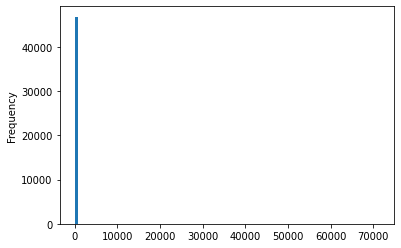

In [50]:
df_dist['CII[gCO2/(nm . tonne)]'].plot(kind='hist',bins=100)

In [51]:
df_dist_tmp = df_dist[df_dist['CII[gCO2/(nm . tonne)]'] < 250]

In [52]:
df_dist.groupby('Ship_type').agg({'CII[gCO2/(nm . tonne)]':agg_req})\
.sort_values(by=[('CII[gCO2/(nm . tonne)]', 'median')], ascending=False)

CII[gCO2/(nm . tonne)]                          \
                                             mean      median         std   
Ship_type                                                                   
Passenger ship                         176.748762  139.129507  170.309337   
Ro-pax ship                            173.772494  112.669947  201.362809   
Ro-ro ship                              34.162195   31.398834   16.975180   
Refrigerated cargo carrier              23.657975   23.290011    7.238835   
Other ship types                        35.848463   17.358105   95.570296   
Vehicle carrier                         20.609056   17.011019   55.040377   
Container/ro-ro cargo ship              19.919350   15.577591   12.147470   
General cargo ship                      14.381446   13.923367    7.124829   
Gas carrier                             16.658445   13.675898   10.904533   
Combination carrier                     17.557986   11.294729   14.388433   
Container ship                          19.665812    9.753317  655.922057   
LNG carrier                             11.600060    9.277244   30.347984   
Chemical tanker                         13.975093    9.113610  225.061655   
Bulk carrier                             6.859749    5.164388   86.504716   
Oil tanker                              16.123731    4.723770  824.049384   

                                                     
                                  min           max  
Ship_type                                            
Passenger ship              22.342860   2612.719250  
Ro-pax ship                  8.534246   1787.480135  
Ro-ro ship                   7.042203    159.643919  
Refrigerated cargo carrier   7.452867     64.906184  
Other ship types             3.710588   1076.363512  
Vehicle carrier              1.590031   2210.852945  
Container/ro-ro cargo ship   4.487801    114.422136  
General cargo ship           1.466900    274.983542  
Gas carrier                  2.820199    182.481331  
Combination carrier          2.581852     46.037601  
Container ship               1.177438  55456.853239  
LNG carrier                  1.494596    765.917501  
Chemical tanker              0.750349  16484.086597  
Bulk carrier                 0.268193   7071.358498  
Oil tanker                   0.875416  71386.079939

In [53]:
df_dist_tmp = df_dist[df_dist['CII[gCO2/(nm . tonne)]'] < 500]

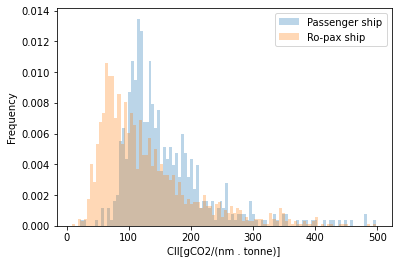

In [54]:
fig, ax = plt.subplots()
df_dist_tmp[df_dist_tmp['Ship_type'] == 'Passenger ship']['CII[gCO2/(nm . tonne)]'].plot(kind='hist', alpha=.3, label='Passenger ship', ax=ax, bins=100, density=True);
df_dist_tmp[df_dist_tmp['Ship_type'] == 'Ro-pax ship']['CII[gCO2/(nm . tonne)]'].plot(kind='hist', alpha=.3, label='Ro-pax ship', ax=ax, bins=100, density=True);

ax.legend();
ax.set_xlabel('CII[gCO2/(nm . tonne)]');

In [55]:
df_dist_tmp = df_dist[df_dist['CII[gCO2/(nm . tonne)]'] < 500]

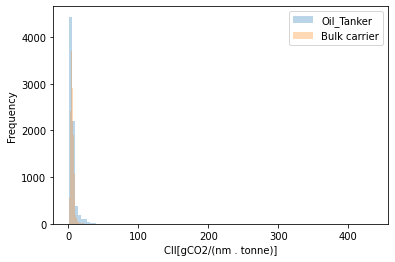

In [56]:
fig, ax = plt.subplots()
df_dist_tmp[df_dist_tmp['Ship_type'] == 'Oil tanker']['CII[gCO2/(nm . tonne)]'].plot(kind='hist', alpha=.3, label='Oil_Tanker', ax=ax, bins=100);
df_dist_tmp[df_dist_tmp['Ship_type'] == 'Bulk carrier']['CII[gCO2/(nm . tonne)]'].plot(kind='hist', alpha=.3, label='Bulk carrier', ax=ax, bins=100);

ax.legend();
ax.set_xlabel('CII[gCO2/(nm . tonne)]');

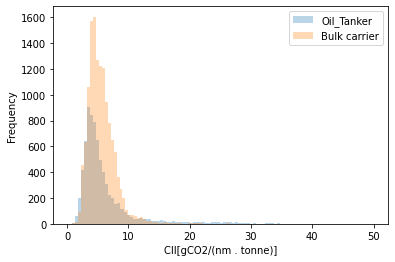

In [57]:
df_dist_tmp = df_dist[df_dist['CII[gCO2/(nm . tonne)]'] < 50]
fig, ax = plt.subplots()

df_dist_tmp[df_dist_tmp['Ship_type'] == 'Oil tanker']['CII[gCO2/(nm . tonne)]'].plot(kind='hist', alpha=.3, label='Oil_Tanker', ax=ax, bins=100);
df_dist_tmp[df_dist_tmp['Ship_type'] == 'Bulk carrier']['CII[gCO2/(nm . tonne)]'].plot(kind='hist', alpha=.3, label='Bulk carrier', ax=ax, bins=100);

ax.legend();
ax.set_xlabel('CII[gCO2/(nm . tonne)]');


So it appears that Passenger Ships and Ferries (Roll-on / Roll-off) have the highest median and mean CII

Bulk Carrier and Oil Tankers are the lowest.

<a id='dwt'></a>
### Emmission Intensity vs DWT

There are likley some outliers in the data for Emmission intensity. Orders of magnitude greater than rest. I'll limit the CII[gCO2/(nm . tonne)] to 500.

In [58]:
df_dist_tmp = df_dist[df_dist['CII[gCO2/(nm . tonne)]'] < 500]

In [59]:
df_dist_tmp['dwt'].describe()

count     46738.000000
mean      56540.479546
std       52231.083940
min         461.000000
25%       17614.000000
50%       39975.000000
75%       77171.000000
max      324272.000000
Name: dwt, dtype: float64

In [60]:
df_dist_tmp['dwt_log'] = np.log(df_dist_tmp['dwt'])

/var/folders/h3/gjf9h8qs5hx0m2tbzdm5t69h0dy5s6/T/ipykernel_31818/2665885907.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dist_tmp['dwt_log'] = np.log(df_dist_tmp['dwt'])


In [61]:
df_dist_tmp['CII_log'] = np.log(df_dist_tmp['CII[gCO2/(nm . tonne)]'])

/var/folders/h3/gjf9h8qs5hx0m2tbzdm5t69h0dy5s6/T/ipykernel_31818/553238219.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dist_tmp['CII_log'] = np.log(df_dist_tmp['CII[gCO2/(nm . tonne)]'])


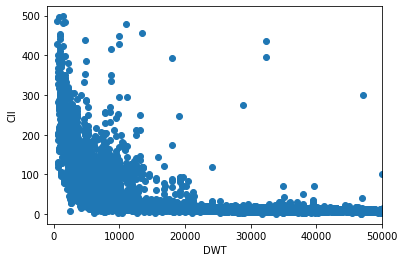

In [62]:
fig, ax = plt.subplots()
ax.scatter(df_dist_tmp['dwt'], df_dist_tmp['CII[gCO2/(nm . tonne)]'])
ax.set_xlim(-1e3,5e4);
ax.set_xlabel('DWT')
ax.set_ylabel('CII');

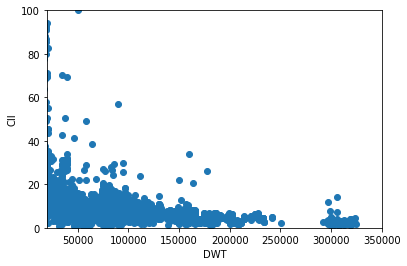

In [63]:
fig, ax = plt.subplots()
ax.scatter(df_dist_tmp['dwt'], df_dist_tmp['CII[gCO2/(nm . tonne)]'])
ax.set_xlim(20e3,350e3)
ax.set_ylim(0,100);
ax.set_xlabel('DWT')
ax.set_ylabel('CII');

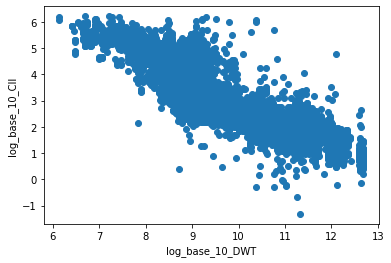

In [64]:
fig, ax = plt.subplots()
ax.scatter(df_dist_tmp['dwt_log'], df_dist_tmp['CII_log'])
ax.set_xlabel('log_base_10_DWT')
ax.set_ylabel('log_base_10_CII');

There is a non-linear (logarithmic) relationship between DWT and CII. This is clear by noticing the significatn benefits to CII as DWT increases from 500 to 15-20K DWT. However, beyond 20000 DWT. The gains in efficiency begins to drop off. 

There is a linear relationship between the log(CII) vs log(DWT). This is clear in the final scatter plot.